# Lab 8 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction: https://canvas.uw.edu/courses/1548925/files/92225287?wrap=1

### Team Members:

### Dataset for your project:

#### Feel free to delete or modify pre-written markdown cells below the line

---

## Understanding the Data

In [389]:
import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import pandas as pd

In [390]:
data = pd.read_csv("/Users/mariea/Desktop/Lab8/emotions.csv")
print(data.head)
data = data.to_numpy()
print(data.shape)
x_data = data[:, :2548]
targets = data[:, 2548]
print(x_data.shape)
print(targets.shape)



<bound method NDFrame.head of       # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  \
0          4.620      30.3    -356.0     15.60      26.3       1.070   
1         28.800      33.1      32.0     25.80      22.8       6.550   
2          8.900      29.4    -416.0     16.70      23.7      79.900   
3         14.900      31.6    -143.0     19.80      24.3      -0.584   
4         28.300      31.3      45.2     27.30      24.5      34.800   
...          ...       ...       ...       ...       ...         ...   
2127      32.400      32.2      32.2     30.80      23.4       1.640   
2128      16.300      31.3    -284.0     14.30      23.9       4.200   
2129      -0.547      28.3    -259.0     15.80      26.7       9.080   
2130      16.800      19.9    -288.0      8.34      26.0       2.460   
2131      27.000      32.0      31.8     25.00      28.9       4.990   

      mean_d_1_a  mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  \
0          0.411     -15.700     

In [391]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
print(x_data[0])

targets = targets.reshape(-1, 1)
print(x_data.dtype)
print(targets.dtype)

[-0.69608594  0.35491199 -1.21724379 ... -1.06084278 -1.06084278
  0.91015287]
float64
object


In [392]:
name_to_num = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
for i in range(0, len(targets)):
    targets[i][0] = name_to_num[targets[i][0]]

print(targets[:3])
print(targets.dtype)


[[0]
 [1]
 [2]]
object


In [393]:
targets = np.concatenate(targets).astype(int)
print(targets.dtype)

int64


In [394]:
test_features = x_data[:300,:]
test_targets = targets[:300]

validation_features = x_data[300:600, :]
validation_targets = targets[300:600]

train_features = x_data[600:,:]
train_targets = targets[600:]


print(test_features.shape)
print(test_targets.shape)

print(validation_features.shape)
print(validation_targets.shape)

print(train_features.shape)
print(train_targets.shape)

(300, 2548)
(300,)
(300, 2548)
(300,)
(1532, 2548)
(1532,)


In [395]:
class EmotionsCNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EmotionsCNN, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, 2048)
        self.linear3 = torch.nn.Linear(2048, 1024)
        self.linear4 = torch.nn.Linear(1024, 512)
        self.linear5 = torch.nn.Linear(512, output_dim)

        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(2048)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        self.bn4 = torch.nn.BatchNorm1d(512)
        

    def forward(self, x):
        out = torch.nn.functional.relu(self.linear1(x))
        out = self.bn1(out)
        out = torch.nn.functional.relu(self.linear2(out))
        out = self.bn2(out)
        out = torch.nn.functional.relu(self.linear3(out))
        out = self.bn3(out)
        out = torch.nn.functional.relu(self.linear4(out))
        out = self.bn4(out)
        out = self.linear5(out)


        return out

In [396]:
torch.manual_seed(55)


cnn = EmotionsCNN(input_dim=train_features.shape[1], hidden_dim=4096, output_dim=3)

learning_rate = 0.0003
epochs = 20
batchsize = 300

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

cnn

EmotionsCNN(
  (linear1): Linear(in_features=2548, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=3, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [397]:
train_loss_list = []

validation_accuracy_list = np.zeros((epochs,))

train_features = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_features = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()


test_features = torch.from_numpy(test_features).float()
test_targets = torch.from_numpy(test_targets).long()




train_batches_features = torch.split(train_features, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

batch_split_num = len(train_batches_features)

In [398]:
for epoch in range(epochs):
    for k in range(batch_split_num):
        optimizer.zero_grad()
        train_outputs = cnn(train_batches_features[k])
        loss = loss_func(train_outputs, train_batches_targets[k])

       
        loss.backward()
        optimizer.step()
    train_loss_list.append(loss.item())
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    with torch.no_grad():
        validation_outputs = cnn(validation_features)
        
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()
    


epoch 0, loss 0.18022435903549194
epoch 1, loss 0.04036987945437431
epoch 2, loss 0.005012006498873234
epoch 3, loss 0.0028668418526649475
epoch 4, loss 0.002759535564109683
epoch 5, loss 0.000830235832836479
epoch 6, loss 0.0009109450038522482
epoch 7, loss 0.0004883299698121846
epoch 8, loss 0.0004035834572277963
epoch 9, loss 0.00036618649028241634
epoch 10, loss 0.0003333693603053689
epoch 11, loss 0.0002991473884321749
epoch 12, loss 0.00027189531829208136
epoch 13, loss 0.00025090447161346674
epoch 14, loss 0.00023431815498042852
epoch 15, loss 0.00022052033455111086
epoch 16, loss 0.0002082858409266919
epoch 17, loss 0.00019697050447575748
epoch 18, loss 0.00018658925546333194
epoch 19, loss 0.0001772874966263771


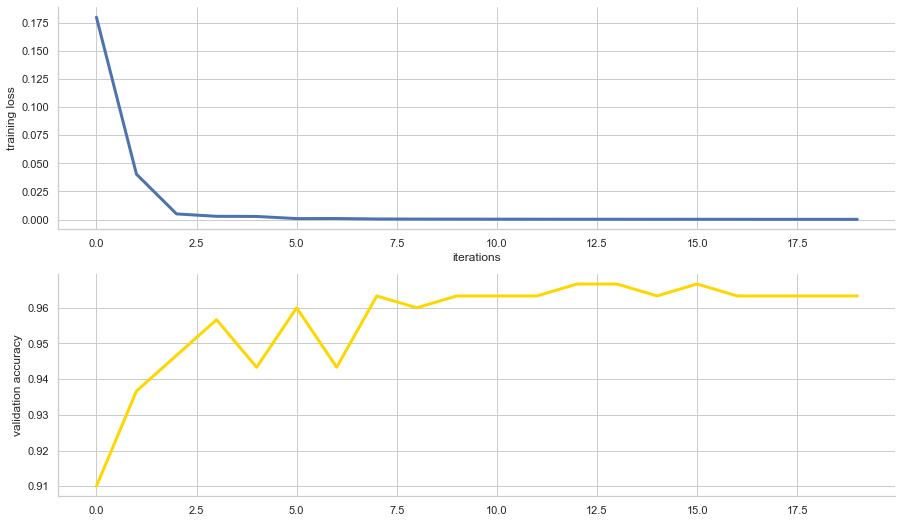

In [399]:
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [400]:
with torch.no_grad():
    test_predict = cnn(test_features)
    
    test_correct = (torch.argmax(test_predict, dim=1) == test_targets).type(torch.FloatTensor)
    print("Testing Accuracy:", test_correct.mean().numpy()*100, "%")

Testing Accuracy: 95.6666648387909 %


In [401]:

num_to_name = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

all_labels = []
all_predictions = []

with torch.no_grad():
   
        
    outputs = cnn(test_features)
    _, predicted = torch.max(outputs, 1)
    all_labels.extend(test_targets.numpy())
    
    all_predictions.extend(predicted.numpy())
    
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

for i in range(0, 3):
    class_indices = np.where(all_labels == i)
    class_correct = np.sum(all_predictions[class_indices] == all_labels[class_indices])
    class_total = len(class_indices[0])
    
    print(f'Accuracy of {num_to_name[i]}: {100 * class_correct / class_total:.2f}%')


Accuracy of NEGATIVE: 97.98%
Accuracy of NEUTRAL: 94.34%
Accuracy of POSITIVE: 94.74%
